# Training monitoring

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them ! 

# Step 1 - Import and init

## 1.1 - Python stuffs

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os, sys, time, random
import seaborn as sns 

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from skimage import io, transform, color
from datetime import datetime

from importlib import reload



In [32]:
def init_environment(project_name):
    # Générer un identifiant de run basé sur le timestamp actuel
    run_id = f"{project_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    # Définir le répertoire de run basé sur run_id
    run_dir = os.path.join(os.getcwd(), 'runs', run_id)
    
    # Créer le répertoire de run si nécessaire
    os.makedirs(run_dir, exist_ok=True)
    
    # Définir le répertoire des datasets (à ajuster selon votre structure de répertoires)
    datasets_dir = os.path.join(os.getcwd(), 'datasets')
    
    return run_id, run_dir, datasets_dir

# Initialisation de l'environnement avec votre nom de projet
project_name = 'K3GTSRB3'
run_id, run_dir, datasets_dir = init_environment(project_name)

print(f"Run ID: {run_id}")
print(f"Run Directory: {run_dir}")
print(f"Datasets Directory: {datasets_dir}")


Run ID: K3GTSRB3_20240216_142911
Run Directory: /Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911
Datasets Directory: /Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/datasets


## 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
- A 20% 24x24 L dataset, 10 epochs, 20% dataset, need  1'30 on a CPU laptop. (Accuracy=91.4)\
- A 20% 48x48 RGB dataset, 10 epochs, 20% dataset, need 6'30s on a CPU laptop. (Accuracy=91.5)

`fit_verbosity` is the verbosity during training : 
- 0 = silent, 1 = progress bar, 2 = one line per epoch

In [33]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 10
scale        = 1
fit_verbosity = 1

# Step 2 - Load dataset
Dataset is one of the saved dataset...

In [34]:
def rescale_dataset(x_train, y_train, x_test, y_test, scale=1):
    n_train = int(len(x_train) * scale)
    n_test = int(len(x_test) * scale)

    return x_train[:n_train], y_train[:n_train], x_test[:n_test], y_test[:n_test]

In [35]:
def read_dataset(enhanced_dir, dataset_name, scale=1):
    '''
    Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    
        x_train,y_train, x_test,y_test data, x_meta,y_meta
    '''
    
    start_time = time.time()

    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with h5py.File(filename, 'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test = f['x_test'][:]
        y_test = f['y_test'][:]
        x_meta = f['x_meta'][:]
        y_meta = f['y_meta'][:]

    print('Original shape :', x_train.shape, y_train.shape)
    x_train, y_train, x_test, y_test = rescale_dataset(x_train, y_train, x_test, y_test, scale=scale)
    print('Rescaled shape :', x_train.shape, y_train.shape)

    x_train, y_train = shuffle(x_train, y_train, random_state=42)

    duration = time.time() - start_time
    size = os.path.getsize(filename)
    print(f'\nDataset "{dataset_name}" is loaded and shuffled. ({size} bytes in {duration:.2f} seconds)')
    return x_train, y_train, x_test, y_test, x_meta, y_meta


# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name, scale)

Original shape : (7841, 24, 24, 1) (7841,)
Rescaled shape : (7841, 24, 24, 1) (7841,)

Dataset "set-24x24-L" is loaded and shuffled. (24270160 bytes in 0.04 seconds)


# Step 3 - Have a look to the dataset

In [36]:
def display_and_save_images(images, labels, indices, columns, x_size, y_size, save_as=None):
    
    rows = len(indices) // columns + (1 if len(indices) % columns else 0)
    fig, axes = plt.subplots(rows, columns, figsize=(x_size * columns, y_size * rows))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        ax.imshow(images[idx], cmap='gray', interpolation='nearest')  # Adjust colormap if needed
        ax.set_title(f'Label: {labels[idx]}')
        ax.axis('off')

    for i in range(len(indices), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    if save_as:
        plt.savefig(f'{save_as}.png', dpi=300)
    plt.show()


x_train :  (7841, 24, 24, 1)
y_train :  (7841,)
x_test  :  (2526, 24, 24, 1)
y_test  :  (2526,)


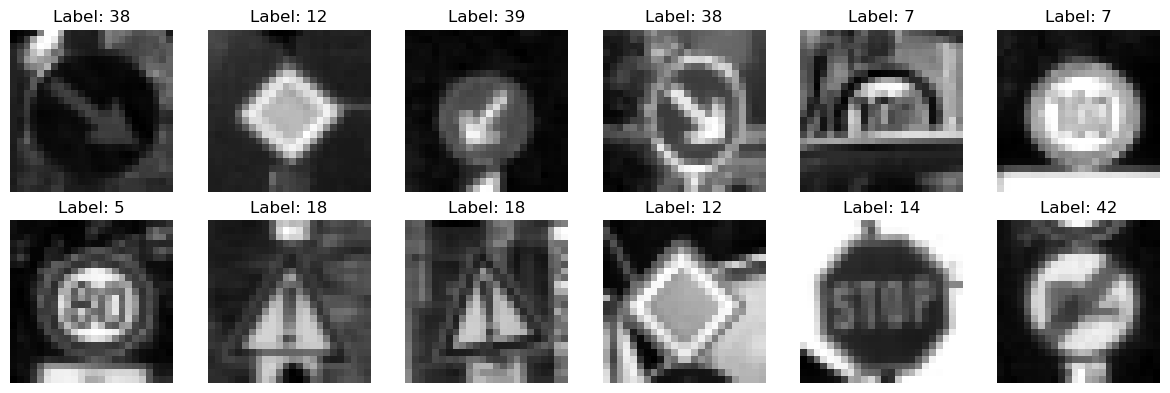

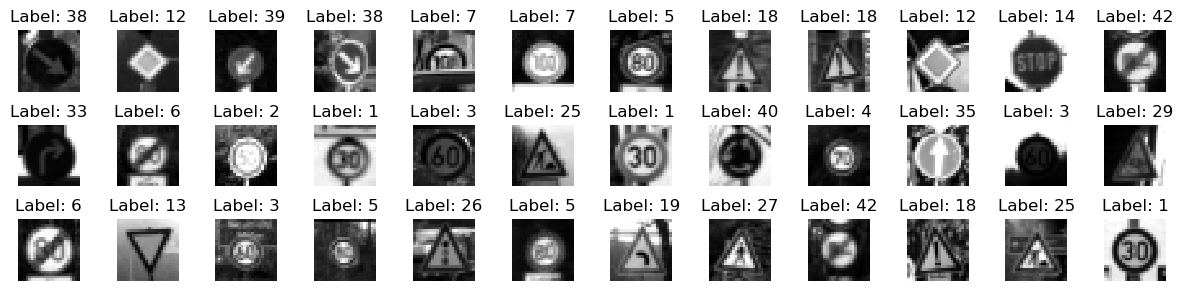

In [37]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

# Afficher et sauvegarder le premier ensemble d'images (taille moyenne)
display_and_save_images(x_train, y_train, range(12), columns=6, x_size=2, y_size=2, save_as='img/01-dataset-medium')

# Afficher et sauvegarder le second ensemble d'images (taille petite)
display_and_save_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='img/02-dataset-small')

# Step 4 - Create model

We will now build a model and train it...
Some models...

In [38]:
# A basic model

def get_model_v1(lx, ly, lz):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(96, (3, 3), activation='relu', input_shape=(lx, ly, lz)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1500, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(43, activation='softmax'))
    return model

## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 See [Keras documentation](https://keras.io/api/callbacks/)

In [39]:
# Création des répertoires pour les modèles et les logs
os.makedirs(os.path.join(run_dir, 'models'), exist_ok=True)
os.makedirs(os.path.join(run_dir, 'logs'), exist_ok=True)

# ---- Callback pour TensorBoard
# Générer un timestamp pour le nom du répertoire
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(run_dir, "logs", "tb_" + current_time)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint pour sauvegarder le meilleur modèle
save_dir = os.path.join(run_dir, "models", "best-models.h5")
best_model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, save_best_only=True, verbose=0, monitor='val_accuracy', mode='max')

# ---- Callback ModelCheckpoint - Sauvegarder le modèle à chaque époque
save_dir_epoch = os.path.join(run_dir, "models", "model-{epoch:04d}.h5")
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir_epoch, verbose=0)

# Affichage du chemin pour exécuter TensorBoard
absolute_path = os.path.abspath(os.path.join(run_dir, 'logs'))
print(f'Pour exécuter TensorBoard : \ntensorboard --logdir={absolute_path}')

Pour exécuter TensorBoard : 
tensorboard --logdir=/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/logs


# Step 6 - Train the model 

#### Get the shape of my data :

In [40]:
(n, lx, ly, lz) = x_train.shape
print("Images of the dataset have this folowing shape : ", (lx, ly, lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


#### Get and compile a model, with the data shape :

In [41]:
model = get_model_v1(lx, ly, lz)

model.summary()

model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 11, 96)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 11, 11, 96)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 192)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 4, 192)        

#### Train it : 

In [42]:
# Démarrer le chronomètre
start_time = time.time()

# Mélanger les données d'entraînement
x_train, y_train = shuffle(x_train, y_train)

# Entraînement du modèle
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=fit_verbosity,
    callbacks=[tensorboard_callback, best_model_callback, savemodel_callback]
)

# Sauvegarder le dernier modèle
model.save(os.path.join(run_dir, 'models', 'last-model.h5'))

# Afficher la durée
end_time = time.time()
print(f"Durée d'entraînement: {end_time - start_time} secondes")


Epoch 1/10
123/123 [==============================] - 17s 132ms/step - loss: 3.0880 - accuracy: 0.1953 - val_loss: 1.9855 - val_accuracy: 0.4470
Epoch 2/10


/Users/jules/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


123/123 [==============================] - 15s 122ms/step - loss: 1.3177 - accuracy: 0.6171 - val_loss: 0.9666 - val_accuracy: 0.7304
Epoch 3/10
123/123 [==============================] - 15s 121ms/step - loss: 0.6876 - accuracy: 0.7968 - val_loss: 0.6534 - val_accuracy: 0.8420
Epoch 4/10
123/123 [==============================] - 15s 121ms/step - loss: 0.4559 - accuracy: 0.8669 - val_loss: 0.5615 - val_accuracy: 0.8709
Epoch 5/10
123/123 [==============================] - 15s 118ms/step - loss: 0.3288 - accuracy: 0.9010 - val_loss: 0.4630 - val_accuracy: 0.8895
Epoch 6/10
123/123 [==============================] - 14s 116ms/step - loss: 0.2436 - accuracy: 0.9285 - val_loss: 0.4260 - val_accuracy: 0.9054
Epoch 7/10
123/123 [==============================] - 14s 112ms/step - loss: 0.1898 - accuracy: 0.9420 - val_loss: 0.4150 - val_accuracy: 0.9030
Epoch 8/10
123/123 [==============================] - 14s 113ms/step - loss: 0.1571 - accuracy: 0.9532 - val_loss: 0.3744 - val_accuracy: 0.9

#### Evaluate it :

In [43]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9192


In [44]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.3815
Test accuracy  : 0.9192


# Step 7 - History
The return of model.fit() returns us the learning history

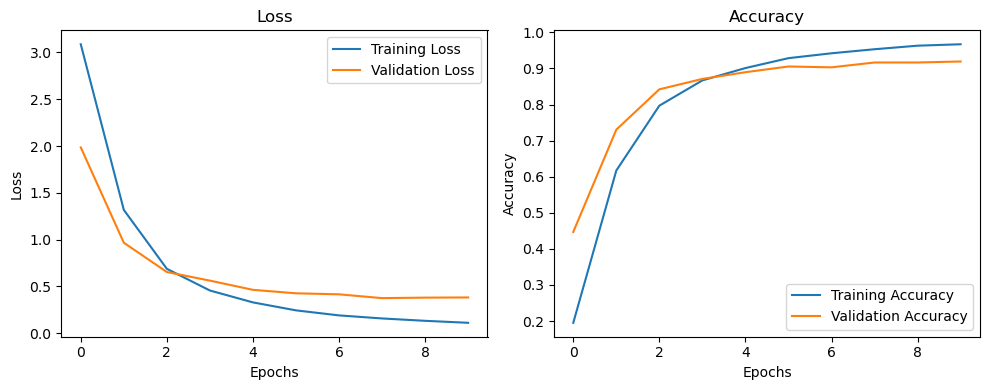

In [45]:
import matplotlib.pyplot as plt

def plot_history(history, save_as=None):
    
    # Perte
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Précision
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    
    if save_as:
        plt.savefig(f'{save_as}.png')
    
    plt.show()

plot_history(history, save_as='img/03-history')


# Step 8 - Evaluation and confusion

In [46]:
def plot_confusion_matrix(y_true, y_pred, classes, figsize=(12, 12), normalize=False, save_as=None):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save_as:
        plt.savefig(f'{save_as}.png', dpi=300)
    plt.show()


79/79 [==============================] - 1s 17ms/step


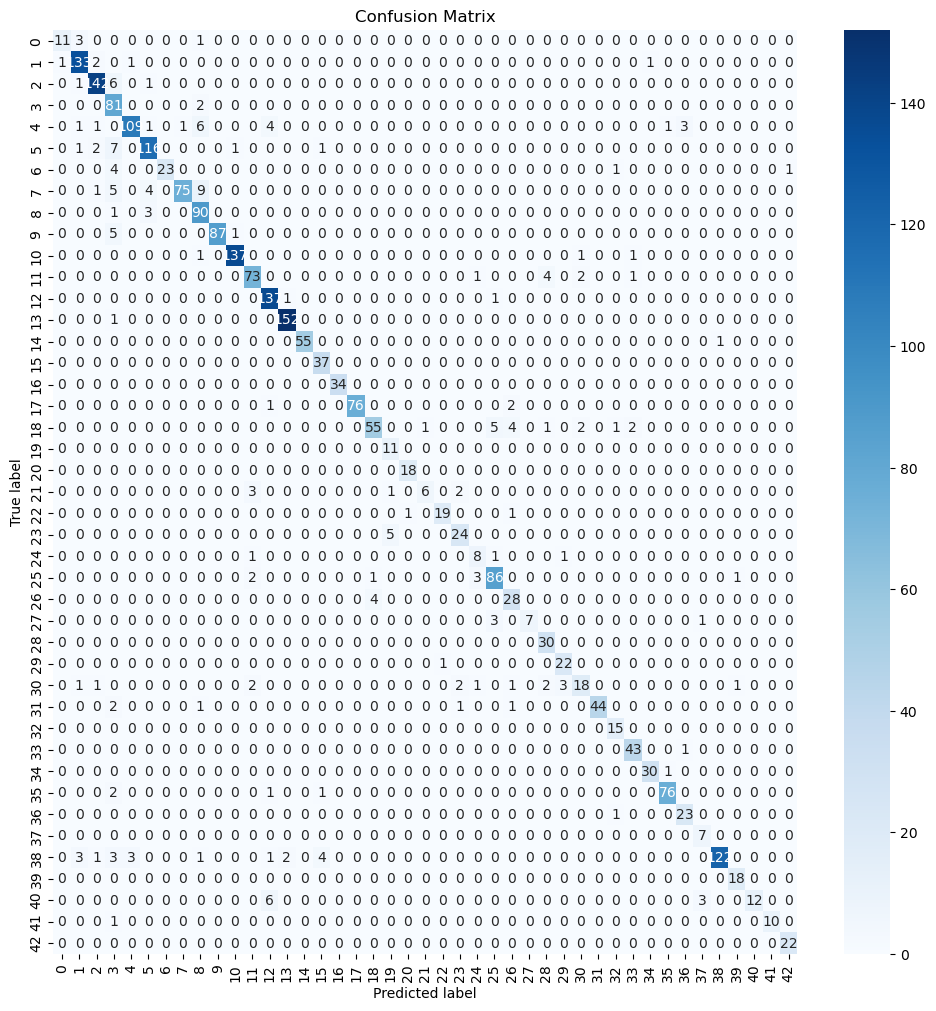

In [47]:
y_sigmoid = model.predict(x_test, verbose=fit_verbosity)
y_pred    = np.argmax(y_sigmoid, axis=-1)
plot_confusion_matrix(y_test, y_pred, classes=range(43), normalize=False, save_as='img/04-confusion-matrix')

## Step 9 - Restore and evaluate
#### List saved models :

In [48]:
!find "$run_dir"/models/

/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models/
/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models//best-models.h5
/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models//model-0007.h5
/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models//model-0003.h5
/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models//model-0002.h5
/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models//model-0006.h5
/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models//model-0009.h5
/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models//model-0008.h5
/Users/jules/Documents/Polytech Lyon/Apprentissage-Panneaux/runs/K3GTSRB3_20240216_142911/models//last-model.h5
/User

#### Restore a model :

In [49]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-models.h5')
# loaded_model.summary()
print("Loaded.")

Loaded.


#### Evaluate it :

In [50]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.3815
Test accuracy  : 0.9192


#### Make a prediction :

1/1 [==============================] - 0s 86ms/step

Output layer from model is (x100) :

[ 0.  22.3 77.7  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0. ]

Graphically : 



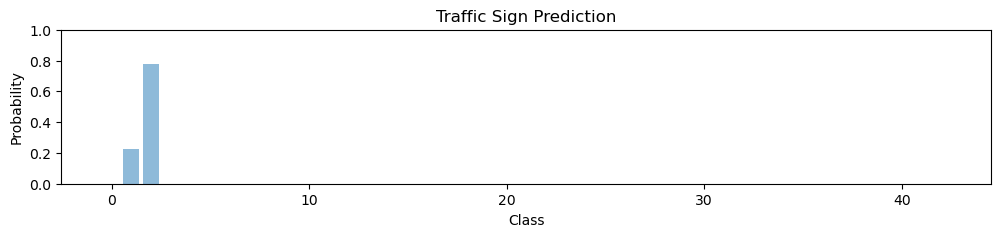


The image : Prediction : Real stuff :


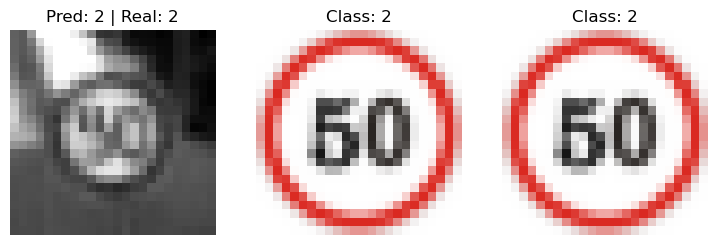

Prediction is correct : 2 == 2


In [51]:
# Choisir une image aléatoire
i = random.randint(0, len(x_test) - 1) 
x, y = x_test[i], y_test[i]

# Faire une prédiction
prediction = loaded_model.predict(np.array([x]))

# Afficher la sortie du modèle
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(prediction[0] * 100)

# Visualisation graphique
print("\nGraphically : \n")
plt.figure(figsize=(12, 2))
plt.bar(range(43), prediction[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0, 1))
plt.xlabel('Class')
plt.title('Traffic Sign Prediction')

# Sauvegarder la figure
plt.savefig('img/05-prediction.png', dpi=300)
plt.show()

# Prédire la classe
p = np.argmax(prediction)

# Afficher le résultat
print(f"\nThe image : Prediction : Real stuff :")
plt.figure(figsize=(9, 6))
for idx, img in enumerate([x, x_meta[p], x_meta[y]], start=1):
    plt.subplot(1, 3, idx)
    plt.imshow(img, cmap='gray')
    plt.title(f'Pred: {p} | Real: {y}' if idx == 1 else f'Class: {p if idx == 2 else y}')
    plt.axis('off')

# Sauvegarder la comparaison
plt.savefig('img/06-prediction.png', dpi=300)
plt.show()

if p == y:
    print(f"Prediction is correct : {p} == {y}")
else:
    print(f"Prediction is incorrect : {p} != {y}")
